In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import tflearn.data_utils as du
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.preprocessing.image import array_to_img
import warnings
import matplotlib.image as mpimg
import os 
import cv2
import tensorflow as tf 
from PIL import Image 
from numpy import asarray
from tqdm import tqdm
from tkinter import Tk     # from tkinter import Tk for Python 3.x
from tkinter.filedialog import askopenfilename


Instructions for updating:
non-resource variables are not supported in the long term
curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [2]:
DIRECTORY = r"C:\Users\rassa\Documents\Machine Learning A-Z  Udemy\Arabic Handwritten Characters Dataset"
train_data = []
test_data = []
trainPath = DIRECTORY + r"\Train Images 13440x32x32\train"
testPath  = DIRECTORY + r"\Test Images 3360x32x32\test"

def getImgId(imgName):
    return int(imgName.split('_')[1])

def makeData(data, directory, sortingCriteria):
    imgFileNameList = os.listdir(directory)     #get list of directories in path (ie. list of image names)
    imgFileNameList.sort(key = sortingCriteria) #sort list based on key
    
    for img in tqdm(imgFileNameList):  # iterate over the sorted list
                try:
                    img_array = cv2.imread(os.path.join(directory, img) ,cv2.IMREAD_GRAYSCALE)  # convert image to array
                    data.append([img_array])  # add this to our data
                except Exception as e:  # just in case there is a mistake.
                    pass

makeData(train_data, trainPath, getImgId)
makeData(test_data, testPath, getImgId)

# convert to ndarray and reshape
train_data = np.asarray(train_data).reshape([-1, 32, 32, 1])
test_data = np.asarray(test_data).reshape([-1, 32, 32, 1])

100%|████████████████████████████████████████████████████████████████████████████| 3360/3360 [00:02<00:00, 1604.89it/s]


In [3]:
#Load the labels
#header = 0 because
#this creates a pandas dataframe (basically a table)
train_label = pd.read_csv(DIRECTORY + '/csvTrainLabel 13440x1.csv', header = None)
test_label = pd.read_csv(DIRECTORY +  '/csvTestLabel 3360x1.csv', header = None)


In [4]:
#train_data = train_data.iloc[:,:].values.astype('float32')
train_label = train_label.iloc[:,:].values.astype('int32')-1
#test_data = test_data.iloc[:,:].values.astype('float32') Not sure if we need this yet
test_label = test_label.iloc[:,:].values.astype('int32')-1


In [5]:
train_label = du.to_categorical(train_label,28)

In [6]:
train_data = train_data/255
test_data = test_data/255

In [7]:
#train_data, mean1 = du.featurewise_zero_center(train_data) Not sure if we need this
#test_data, mean2 = du.featurewise_zero_center(test_data)

In [8]:

recognizer = Sequential()

recognizer.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (32,32,1)))
recognizer.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
recognizer.add(MaxPool2D(pool_size=(2,2)))
recognizer.add(Dropout(0.25))

recognizer.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
recognizer.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
recognizer.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
recognizer.add(Dropout(0.25))


recognizer.add(Flatten())
recognizer.add(Dense(units = 256, input_dim = 1024, activation = 'relu'))
recognizer.add(Dense(units = 256, activation = "relu"))
recognizer.add(Dropout(0.5))
recognizer.add(Dense(28, activation = "softmax"))

In [9]:
recognizer.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

In [10]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [11]:
recognizer.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [12]:
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        zoom_range = 0.1,  
        width_shift_range=0.1, 
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False)

In [13]:
datagen.fit(train_data)

In [14]:
recognizer.fit_generator(datagen.flow(train_data,train_label, batch_size=100),
                             epochs = 30, verbose = 2, steps_per_epoch=train_data.shape[0] // 100)

C:\Users\rassa\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


Epoch 1/30
134/134 - 46s - loss: 2.4791 - acc: 0.2499
Epoch 2/30
134/134 - 40s - loss: 1.4275 - acc: 0.5269
Epoch 3/30
134/134 - 38s - loss: 1.0419 - acc: 0.6443
Epoch 4/30
134/134 - 41s - loss: 0.8254 - acc: 0.7228
Epoch 5/30
134/134 - 44s - loss: 0.7001 - acc: 0.7653
Epoch 6/30
134/134 - 45s - loss: 0.5967 - acc: 0.8058
Epoch 7/30
134/134 - 42s - loss: 0.5215 - acc: 0.8283
Epoch 8/30
134/134 - 40s - loss: 0.4768 - acc: 0.8416
Epoch 9/30
134/134 - 40s - loss: 0.4162 - acc: 0.8655
Epoch 10/30
134/134 - 42s - loss: 0.3879 - acc: 0.8737
Epoch 11/30
134/134 - 40s - loss: 0.3512 - acc: 0.8875
Epoch 12/30
134/134 - 39s - loss: 0.3402 - acc: 0.8921
Epoch 13/30
134/134 - 40s - loss: 0.3042 - acc: 0.9017
Epoch 14/30
134/134 - 39s - loss: 0.2890 - acc: 0.9077
Epoch 15/30
134/134 - 40s - loss: 0.2823 - acc: 0.9100
Epoch 16/30
134/134 - 40s - loss: 0.2518 - acc: 0.9194
Epoch 17/30
134/134 - 38s - loss: 0.2540 - acc: 0.9181
Epoch 18/30
134/134 - 39s - loss: 0.2510 - acc: 0.9206
Epoch 19/30
134/134

In [15]:
predictions = recognizer.predict(test_data)
predictions = np.argmax(predictions,axis = 1)

C:\Users\rassa\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [16]:
cm = confusion_matrix(test_label, predictions)

In [17]:
accuracy = sum(cm[i][i] for i in range(28)) / test_label.shape[0]
print("accuracy = " + str(accuracy))

accuracy = 0.9550595238095239


In [18]:
print(cm)

[[120   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0 119   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1
    0   0   0   0   0   0   0   0   0   0]
 [  0   0 109  10   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   1   0   0   0]
 [  0   0   1 119   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 118   1   0   0   0   0   0   0   0   0   0   0   0   1
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   2 115   1   0   0   0   0   0   0   0   0   0   0   2
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1 119   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 118   2   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   6 108   0   2   0   0   0   0   

* Enter the alpha value [1.0-3.0]: 1.5
* Enter the beta value [0-100]: 0
223.0
[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 9.999974e-01 2.599077e-06 0.000000e+00
  0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 0.000000e+00]]


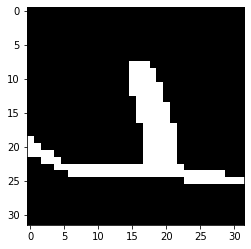

In [20]:

# Read image given by user

Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filename = askopenfilename() # show an "Open" dialog box and return the path to the selected file
image = cv2.imread(filename)#r"C:\Users\rassa\Desktop\Desktop2.0\CNN\9alb-Ba2-0.png") #(cv.samples.findFile(args.input))

contrast_img = np.zeros(image.shape, image.dtype)

alpha = 1.0 # Simple contrast control
beta = 0    # Simple brightness control

# Initialize values
try:
    alpha = float(input('* Enter the alpha value [1.0-3.0]: '))
    beta = int(input('* Enter the beta value [0-100]: '))
except ValueError:
    print('Error, not a number')
    
# Do the operation new_image(i,j) = alpha*image(i,j) + beta
# Instead of these 'for' loops we could have used simply:
# new_image = cv.convertScaleAbs(image, alpha=alpha, beta=beta)
# but we wanted to show you how to access the pixels :)
for y in range(image.shape[0]):
    for x in range(image.shape[1]):
        for c in range(image.shape[2]):
            # the clip makes sure that the new values of the pixel are between 0 and 255
            contrast_img[y,x,c] = np.clip(alpha*image[y,x,c] + beta, 0, 255)
        
#removethe three dimensions and turn image to gray scale
im_gray = cv2.cvtColor(contrast_img, cv2.COLOR_BGR2GRAY)
#binarize the image using Otsu method to get the threshold, binarize to black and white(ie. 255)
th, im_gray_th_otsu = cv2.threshold(im_gray, 128, 255, cv2.THRESH_OTSU)

resized = cv2.resize(im_gray_th_otsu, (32,32), interpolation = cv2.INTER_AREA)

#print the threshold because I'm curious
print(th)

final_img = np.zeros(resized.shape, resized.dtype)
for y in range(resized.shape[0]):
    for x in range(resized.shape[1]):
        if resized[y,x] < 125:     
            final_img[y,x] = 255
        else :
            final_img[y,x] = 0

#Show the images so we can compare them
#cv2.imshow('New Image', im_gray_th_otsu)
#cv2.imshow('Original Image', image)
#cv2.imshow('Contrast image', contrast_img)
#cv2.imshow('resized Image', resized)
#cv2.imshow('final Image', final_img)
plt.imshow(image)
plt.imshow(contrast_img)
plt.imshow(im_gray_th_otsu, cmap='gray', vmin=0, vmax=255)
plt.imshow(resized, cmap='gray', vmin=0, vmax=255)
plt.imshow(final_img, cmap='gray', vmin=0, vmax=255)



final_img = np.asarray(final_img).reshape([-1, 32, 32, 1])
#final_img.reshape([1,32,32,1])
#final_img = np.expand_dims(final_img, -1)

predictions_single = recognizer.predict(final_img)
print(predictions_single)
